In [ ]:
# asdasdsdf

In [2]:
import os
import pandas as pd
import numpy as np

from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

import cufflinks as cf 
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from matplotlib import pyplot as plt
import seaborn as sns

# 中文NLP工具
from string import punctuation
import re

import tqdm 
tqdm.tqdm_notebook().pandas()

pd.set_option('display.max_rows', 300)

In [3]:
df = pd.read_csv('../data/aggregated_data.csv')

In [5]:
df['date'] = pd.to_datetime(df['date'])
df['date'].min(), df['date'].max()

(Timestamp('2020-03-17 00:00:00'), Timestamp('2020-05-30 00:00:00'))

In [45]:
from preprocessing import add_identity
df=add_identity(df)

In [31]:
df.shape

(3630, 28)

In [34]:
df.点赞数.sum()

497735

In [33]:
df.转发数.sum()

35927

In [32]:
df.评论数.sum()

90420

In [36]:
df.nb_interactivity.sum()

627712

## EDA

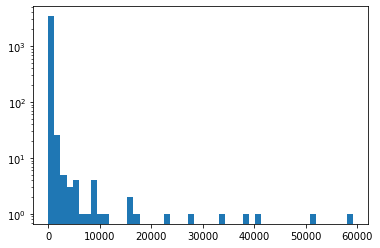

In [7]:
plt.hist(df['nb_interactivity'], bins= 50)
plt.yscale('log')

In [37]:
data = df.groupby('date').agg({'微博正文' : 'count', '转发数':'sum'})[['微博正文','转发数']].reset_index()
data['平均转发数'] = data['转发数']/data['微博正文']
fig = px.bar(data_frame=data, y='微博正文',x='date',text='微博正文')
fig.update_layout(width=1000, title = '五个一政策-每日原创微博数')
fig.show()


In [38]:
fig = df.发布者地区.value_counts().iloc[:15].iplot(kind='barh', asFigure=True)
fig.update_layout(height=400, title='微博发布者所在地区 Count')

In [49]:
df[['if_大V', 'if_官媒','if_自媒','if_个人用户']].sum(axis=0)

if_大V       263
if_官媒       264
if_自媒        91
if_个人用户    3210
dtype: int64

In [66]:
(df[df.发布者地区 == '海外'][['if_大V', 'if_官媒','if_自媒','if_个人用户']].sum(axis=0)/df[df.发布者地区 == '海外'][['if_大V', 'if_官媒','if_自媒','if_个人用户']].sum(axis=0).sum()).round(2)

if_大V      0.02
if_官媒      0.01
if_自媒      0.02
if_个人用户    0.94
dtype: float64

In [67]:
(df[df.发布者地区 == '北京'][['if_大V', 'if_官媒','if_自媒','if_个人用户']].sum(axis=0)/df[df.发布者地区 == '北京'][['if_大V', 'if_官媒','if_自媒','if_个人用户']].sum(axis=0).sum()).round(2)

if_大V      0.19
if_官媒      0.16
if_自媒      0.04
if_个人用户    0.61
dtype: float64

In [65]:
(df[df.发布者地区 == '上海'][['if_大V', 'if_官媒','if_自媒','if_个人用户']].sum(axis=0)/df[df.发布者地区 == '上海'][['if_大V', 'if_官媒','if_自媒','if_个人用户']].sum().sum()).round(2)

if_大V      0.10
if_官媒      0.06
if_自媒      0.03
if_个人用户    0.81
dtype: float64

In [ ]:
df['c'] = 0
df.loc[df['if_大V']==1,'c'] = 1

In [10]:
df[['转发数','评论数','点赞数']].quantile(0.99)

转发数     122.68
评论数     339.72
点赞数    1520.32
Name: 0.99, dtype: float64

In [72]:
delays = (df['date']-df['date'].min()).dt.days.values
(delays**2)/10

array([ 10. ,   8.1,  14.4, ..., 504.1, 504.1, 504.1])

In [80]:
# 关注度
df_temp = df[df['发布者地区'] == '北京']
delays = (df_temp['date'] - df_temp['date'].min()).dt.days.values

# color_pallet = sns.color_palette('RdBu_r',delays.max()+1)

fig=go.Figure(layout=dict(width=800, height=700, title='北京地区对‘五个一政策’ 话题关注度 - 颜色越浅,发布时间越久'))

trace = go.Scatter(
    x=df_temp['发布者粉丝数'],
    y=df_temp['nb_interactivity'],
    opacity=0.7,
    mode='markers',
    marker=dict(
        # size=(delays**2)/500,
        color=delays[::-1]
    ),
    text=df_temp['date'].dt.date
)

fig.add_trace(trace)
fig.update_layout(
    yaxis={'type':'log', 'title':'互动次数'}, 
    xaxis={'type':'log', 'title':'发布者粉丝数'})
fig.show()

In [93]:
df[['微博正文','text_preprocessed']].iloc[809:811].values

array([['易尬一爆炸HAN:从小到大 就被说 没心没肺 很多事情不容易当回事但真的这个五个一 限航政策 想必 我能记很久 甚至一辈子吧 英国·格拉斯哥 \xa0显示地图\xa0',
        '从小到大 就被说 没心没肺 很多事情不容易当回事但真的这个五个一 限航政策 想必 我能记很久 甚至一辈子吧 英国·格拉斯哥 显示地图'],
       ['花花木华Birch:刚刚看了条微博 有感而发 #国际客运航班五个一政策##中国民航局##人民网# \xa0',
        '刚刚看了条微博 有感而发 国际客运航班五个一政策中国民航局人民网']], dtype=object)

## 情感分析

In [119]:
df[(df['sentiment']==1)][['微博正文','sentiment']].values.tolist()

“一个中国人一旦出国当了一个留学生就会一直买不到一张回国的机票，简称五个一”哈 哈 哈 哈 哈 哈🖕🏻这就是三月份老老实实听话就地隔离的结果吗 美国·University of California Irvine \xa0显示地图\xa0',
  1],
 ['和平蹲小:@中国民航网 请问什么时候能够放宽“五个一”政策？原因如下：1.现在在欧美一些国家，疫情已经有一些好转。“五个一”政策虽然能够阻断病毒输入性传播，但是这已经是三月份出的政策，应该适时改变政策，放宽这些政策（已经有一些不符合现在实际）2.留学生想乘入境航班回家，但由于我国“五个一”政策，致使来自慕尼黑 纽约等地留学生未能归国，相反“助长”了归国航班贵 航班少的态势。我恳请总局大大能够酌情考虑，做出适当的适时的决策。\xa0',
  1],
 ['-展红绫:谁会想到这是我最近吃的最好的一顿饭……天天吃面真的有些恶心辛拉面 火鸡面 汤达人 红烧牛肉面 鲜虾鱼板面 香辣牛肉面 宜宾燃面 红油面皮 日式乌冬面 红薯宽粉 螺蛳粉大概两个月了吧五个一 政策 很好反正我知道航班被取消 马上下单了洗碗机 正好开学搬家还能用好在快递都恢复了我爱任天堂如果这段隔离时期 没有它现在我也不在了\xa0原图\xa0',
  1],
 ['Veneno小嘉:一个中国人一旦出了国当了一个留学生就会一直买不到一张回国的机票，简称五个一政策@中国民航网 英国·谢菲尔德 \xa0显示地图\xa0',
  1],
 ['投行事儿哥:网友：在某发言人使用人道一词词抨击美国反制中国包机的举措后，这种并不少见的论调现在有了一个统一的名字了：严防死守境外输入性病例，确保国内顺利复工复产、防止疫情二次爆发，才是保护此时身处国内的千千万同胞的最大的「人道主义」，为此归国人员做出牺牲需要理解。这种论调的巧妙之处在于，它给归国人员背上了不可推卸的道德包袱：哪怕你爱国守法、全力配合国内防护工作，只要你物理上回到了疫情已得到控制的中国，你就客观上带来了输入性病例的风险，于是你便对国内的防疫大局、乃至千千万国内同胞的生命健康和正常生活带来了威胁。识别这种论调的谬误之处需要从两方面考虑：「五个一」政策本身是否能起到有效保障国内防疫大局的效果——或者说，倘若这一政策做出调整，是否真的会对国内防疫大局造成显著的破坏？而这一政策的制定逻辑，是否又遵循了人道主义、生命至

In [95]:
df.sentiment.value_counts()

0    2191
2    1297
1     142
Name: sentiment, dtype: int64

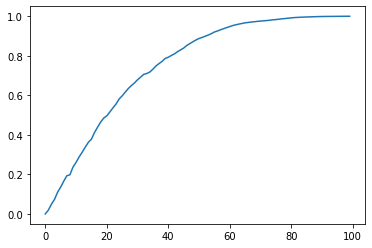

In [129]:
plt.plot([df['confidence'].quantile(i*0.01) for i in range(100)])

In [122]:
df['positive'] = 0
df['negative'] = 0
df['neutre'] = 0

df.loc[df['sentiment'] == 2, 'positive'] = 1
df.loc[df['sentiment'] == 0,'negative'] = 1
df.loc[df['sentiment'] == 1,'neutre'] = 1

In [135]:
import plotly.figure_factory as ff

df_temp = df[df['confidence'] > 0.8]
# 不同情感的微博每日数量
data = df_temp.groupby('date').agg({
    'positive':'sum',
    'negative':'sum',
    'neutre':'sum',
    })

# data = pd.DataFrame(data.values / data.sum(axis=1).values.reshape(-1,1), index=data.index, columns=data.columns)

data = pd.melt(data.reset_index(), id_vars='date', value_vars=['positive','negative','neutre'])

fig = px.bar(data_frame=data, x='date',y='value',color='variable', )
fig.update_layout(
    height=300,
    width=800,
    title='情感分析变化 数值')
fig.show()

# 不同情感的微博每日比例
data = df_temp.groupby('date').agg({
    'positive':'sum',
    'negative':'sum',
    'neutre':'sum',
    })

data = pd.DataFrame(data.values / data.sum(axis=1).values.reshape(-1,1), index=data.index, columns=data.columns)

data = pd.melt(data.reset_index(), id_vars='date', value_vars=['positive','negative','neutre'])

fig = px.bar(data_frame=data, x='date',y='value',color='variable', )
fig.update_layout(
    height=300,
    width=800,
    title='情感分析变化 相对比例')
fig.show()

# 置信度

fig = ff.create_distplot([df_temp.loc[df_temp['sentiment'] == 2, 'confidence'].values,
                          df_temp.loc[df_temp['sentiment'] == 0, 'confidence'].values], ['Positive', 'Negative'], bin_size=[0.05, .025])
fig.update_layout(width=800, height=500, title='Confidence Distribution')
fig.show()

In [18]:
def add_identity(df):
    
    # 如何界定大V , 50w 粉丝 
    df['if_大V'] = 0
    df.loc[df['发布者粉丝数']>=500000, 'if_大V'] = 1

    # 多粉 少互动
    df['if_官媒'] = 0
    df.loc[(df['nb_interactivity']/(df['发布者粉丝数']+1)) < 0.00002, 'if_官媒'] = 1

    # 多粉 高互动`
    df['if_自媒'] = 0
    df.loc[((df['nb_interactivity']/(df['发布者粉丝数']+1))>0.0005)&(df['发布者粉丝数']>50000), 'if_自媒'] = 1

    # 身份修正
    ## 官媒 list
    l1 = ['中国民航网','']
    df.loc[df['发布者姓名'].isin(l1), 'if_官媒'] = 1
    df.loc[df['发布者姓名'].isin(l1), 'if_自媒'] = 0
    df.loc[df['发布者姓名'].isin(l1), 'if_个人用户'] = 0

    ## 自媒 list
    l2 = ['小qqq阿','胡舒立','FATIII']
    df.loc[df['发布者姓名'].isin(l2), 'if_官媒'] = 0
    df.loc[df['发布者姓名'].isin(l2), 'if_自媒'] = 1
    df.loc[df['发布者姓名'].isin(l2), 'if_个人用户'] = 0

    # 其他 
    df['if_个人用户'] = 0
    df.loc[(df['if_大V'] == 0) & (df['if_官媒'] == 0) & (df['if_自媒'] == 0),'if_个人用户'] = 1

    return df
df = add_identity(df)

In [19]:
df[['if_大V', 'if_官媒','if_自媒','if_个人用户']].sum(axis=0)

if_大V       241
if_官媒       258
if_自媒        71
if_个人用户    2830
dtype: int64

In [127]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=['负面', '中性','正面'], 
                     values=df[df['发布者地区']=='海外']['sentiment'].value_counts().sort_index(), 
                     hole=.6,
                     name = '海外微博情绪'), 1,1)
fig.add_trace(go.Pie(labels=['负面', '中性','正面'], 
                     values=df[df['发布者地区'] !='海外']['sentiment'].value_counts().sort_index(), 
                     hole=.6,
                     name = '非海外微博情绪'), 1,2)

fig.update_traces(hole=0.5, hoverinfo='label+percent+name')
fig.update_layout(
    title_text = '海外/国内 对待五个一政策 微博情感分析',
    annotations=[dict(text='海外', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='国内', x=0.82, y=0.5, font_size=20, showarrow=False)]
)

fig.show()

In [23]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'}]])

fig.add_trace(go.Pie(labels=['负面', '中性','正面'], 
                     values=df[df['if_官媒']==1]['sentiment'].value_counts().sort_index(), 
                     hole=.6,
                     name = '官媒微博情绪'), 1,1)
fig.add_trace(go.Pie(labels=['负面', '中性','正面'], 
                     values=df[df['if_自媒'] == 1]['sentiment'].value_counts().sort_index(), 
                     hole=.6,
                     name = '自媒微博情绪'), 1,2)
fig.add_trace(go.Pie(labels=['负面', '中性','正面'], 
                     values=df[df['if_个人用户'] == 1]['sentiment'].value_counts().sort_index(), 
                     hole=.6,
                     name = '个人用户微博情绪'), 1,3)

fig.update_traces(hole=0.5, hoverinfo='label+percent+name')
fig.update_layout(
    title_text = '各种类型媒体 对待五个一政策 微博情感分析',
    annotations=[dict(text='官媒', x=0.1, y=0.5, font_size=20, showarrow=False),
                 dict(text='自媒', x=0.5, y=0.5, font_size=20, showarrow=False),
                 dict(text='个人', x=0.9, y=0.5, font_size=20, showarrow=False)]
)

fig.show()

## 词云

In [10]:
import jieba

jieba.load_userdict('../user_dict/dict.txt')

texts = df['text_preprocessed'].values.tolist()
texts_splited = []
for s in texts:
    texts_splited.append(' '.join([i for i in jieba.cut(s,use_paddle=True)]))

df['texts_splited'] = texts_splited

def get_stopwords(path):
    with open(path, 'r', encoding="utf8") as f:
        stopwords = [line.strip() for line in f.readlines()]    
    stopwords = list(set(stopwords))

    return stopwords


from wordcloud import WordCloud

def plot_wordcloud(words, stopwords, path = '../output/词云.png'):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(words)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(path ,dpi=400)

stopwords = get_stopwords('../user_dict/dict.txt') +\
    ['客运','航班','可能','知道','就是','可以','不是',
    '不能','因为','显示','原图','我们','你们','自己',
    '还是','地图','真的','没有','这个','什么','他们',
    '现在','但是','如果']
plot_wordcloud(' '.join(texts_splited))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\36326\AppData\Local\Temp\jieba.cache
Loading model cost 0.911 seconds.
Prefix dict has been built successfully.


In [152]:
from wordcloud import WordCloud

def plot_wordcloud(words, path = '../output/词云.png'):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=1000).generate(words)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(path ,dpi=400)

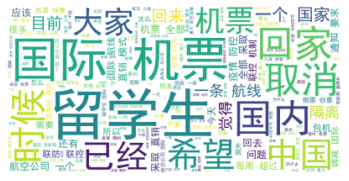

In [153]:
plot_wordcloud(' '.join(texts_splited))

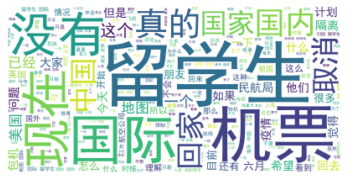

In [13]:
#
plot_wordcloud(' '.join(df[df['发布者地区']=='海外']['texts_splited'].values), '../output/词云_海外.png')

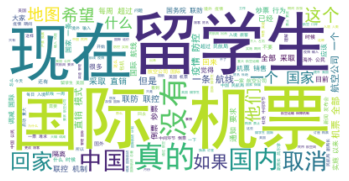

In [14]:
plot_wordcloud(' '.join(df[df['发布者地区']!='海外']['texts_splited'].values), '../output/词云_国内.png')

### Save reformed Data

# TO DO List

- 数据来源分析 
- EDA  <--
    - ~~基本数据情况~~
    - ~~大V关注度~~
    - ~~留学生分析~~
    - ~~关注度时间变化~~

- 微博情感分析
    - ~~数据预处理~~
    - ~~api~~
    - 自己做模型
    - 